<h2 align=center>Image Generation with Deep Convolutional Genrative Adverserial Networks</h2>

## Project Overview and Import Libraries

The objective of the model is to generate fashionable clothing items resembling the fashion mnist dataset. The DCGAN will be used to learn a mapping from a random gausian noise to images in the training distribution in an attempt to produce images that are as close to the ground truth as possible. <br/>

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
from keras.callbacks import ModelCheckpoint
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.3.1


## Load and Preprocess the Data

Loading in the dataset through tensorflow. The pixel values of the images range from 0 to 255 which is a problem unless normalising the pixel values. The network would otherwise have to process larger weight values which would lead to slower convergence and poorer performance.

First, typecast them as float32 (FIND OUT WHY) <br/>
Second, divide by 255

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

Plotting the first 25 images in the dataset in a 5x5 grid to visually evaluate the dataset that is going to be used. It is clear that there is a large range of images.

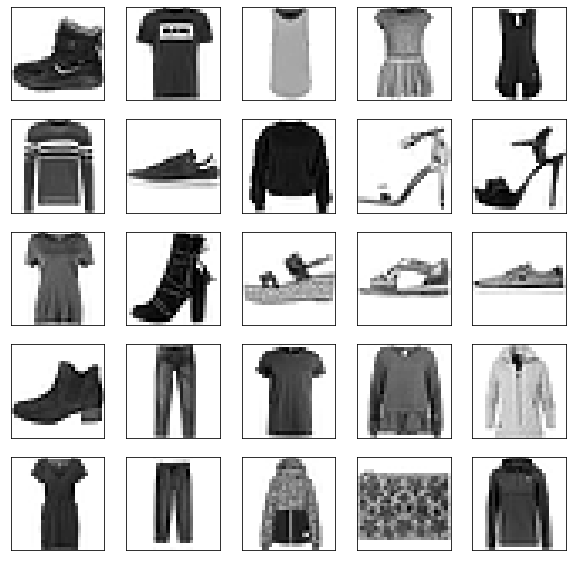

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False) #Removing unnecessary information from plot
    plt.imshow(x_train[i], cmap=plt.cm.binary) #cmap is used for greyscale images as the dataset is black and white
plt.show()

## Create Batches of Training Data

Data is batched and shuffled so it can be fed to the generator and descriminator models in mini-batches of tensors. The batch size is set to a managable number so it can fit in memory easily for training. The images are shuffled with a buffer size of 1000. This means that a buffer is being filled with 1000 elements and elements are randomly sampled from this.

In [4]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1) #drop remainder is set to true so tensorflow ignores the last batch for a full shape propagation.

## Build the Generator Network for DCGAN

The GAN will take an input of dimension specified by the user. In this case 128,128,1 of random noise. This will be passed throught the generator network so that every output of random noise will correspond to a sample from the training distribution. The model will learn through a game theoretic formulation as if it were a two player game. The two adverserial players being the generator and discriminator networks. The generator will try to fool the discriminator by generating as close to realistic looking images as possible, while the discriminator tries to discern whether or not the input image is real or fake

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

It was previously recommended in the 2016 paper outlined above, that gans use a relu activation function, however, empirical observation shows that using the scaled exponential linear unit (SeLU) improves the convergence speed of the DCGAN. Using SeLU without batch normalisation results in mode collapse, so this layer is added after.

In [5]:
num_features = 100 #can be tweaked for network performance depending on compute power available

generator_input = keras.Input(shape=(num_features))

x = layers.Dense(7 * 7 * 128)(generator_input)
x = layers.Reshape((7, 7, 128))(x)
x = layers.BatchNormalization()(x)
#using conv2dtranspose for upsampling the tensor to produce an image of desired size
x = layers.Conv2DTranspose(64, (4,4), (2,2), padding='same', activation='selu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, (5,5), (1,1), padding='same', activation='selu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(16, (5,5), (1,1), padding='same', activation='selu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(1, (4,4), (2,2), padding='same', activation='tanh')(x)

generator = keras.models.Model(generator_input, x) #Instantiates the generator model, which maps the input of shape (num_features) into an image of shape (28, 28, 1)
generator.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 90)]              0         
_________________________________________________________________
dense (Dense)                (None, 6272)              570752    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        131136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 32)       

Creating a random noise input that will be passed through the generator to see what the output is before training the network. 

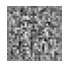

In [6]:
noise = tf.random.normal(shape=[1, num_features])
generated_image = generator(noise, training=False)

def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

show(generated_image, 1)

## Build the Discriminator Network for DCGAN

The discriminator is a binary cnn image classifier that is used to distinguish real images from the dataset and fake images created by the generator. Based off Radfords recommendation. 

In [7]:
discriminator_input = keras.Input(shape=(28,28,1))

x = layers.Conv2D(64, (5,5), (2,2), padding='same')(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(128, (5,5), (2,2), padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)        

Testing the decision of the discriminator on a sample of random noise to evaluate its output and ensure the model is working. The output will be a value between 0 and 1 due to the final sigmoid layer in the network. Closer to 0 suggests that the image is fake and 1 that the image is real. 

In [8]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5042322]], shape=(1, 1), dtype=float32)


Being an untrained network, the output is going to be inaccurate, however, the discriminator still predicted the image to be 0.49 which is leaning towards fake.

## Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

Compiling the discriminator, using binary crossentropy for loss and rmsprop as the optimizer. Training is set to false here as it does not yet need to be trained

In [9]:
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer)
discriminator.trainable = False

gan = keras.models.Sequential([
    generator, discriminator
])

gan_optimizer = keras.optimizers.RMSprop(lr=0.0002, clipvalue=1.0, decay=1e-8)
gan.compile(loss='binary_crossentropy', optimizer=gan_optimizer)

## Define Training Procedure

In order to get a clear understanding of how the output is changing over time, a gif will be created from a seed of random gaussian noise. First, the discriminator network will be trained, and then the generator network. For each step in training the discriminator, a mini-batch of fake images from the previously made gaussian noise which will be passed through the generator, and a mini-batch of real sample images from the training data will be used.

In [10]:
seed = tf.random.normal(shape=[batch_size, num_features]) #seed for tracking performance of network over time

function provided by tensorflow for saving generated outputs (only 'generate_and_save_images' function)

In [11]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

creating two lists to append the losses after every epoch

In [12]:
d_loss = []
a_loss = []

In [13]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)): #using tqdm to show a progress bar and training time
        print('Epochs {}/{}'.format(epoch + 1, epochs))

        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features]) #sample mini batch of noise
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0) #combined dataset of real and fake images for training
            
            #specifying the class labels 0-fake, 1-real
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True #start training the discriminator
            dis_loss = discriminator.train_on_batch(X_fake_and_real, y1)
            dis_loss

            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False #stop training discriminator and begin training generator
            gen_loss = gan.train_on_batch(noise, y2)
            gen_loss

        gan.save_weights('gan.h5') #saving model weights
        d_loss.append(dis_loss)
        a_loss.append(gen_loss) #tracking the loss each epoch by appending to list

        display.clear_output(wait=True) #refreshing the output after every epoch for gif
        generate_and_save_images(generator, epoch + 1, seed) #using the function provided by tensorflow

    display.clear_output(wait=True) 
    generate_and_save_images(generator, epoch, seed) 

## Train DCGAN

In [14]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. -1.#scaling and reshaping training input

In [15]:
#creating batch of training data from fashion mnist dataset
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1) #prefetch minibatches of data

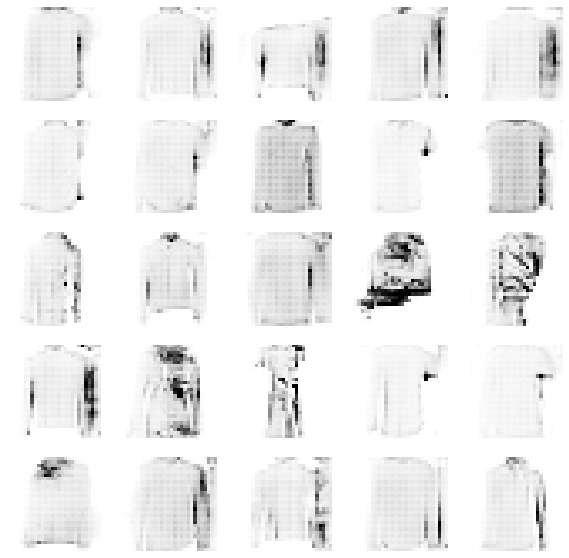

 87%|████████▋ | 87/100 [48:57<07:19, 33.77s/it]


KeyboardInterrupt: 

In [16]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=100)

In [17]:
def loss_plot():
    plt.plot(d_loss)
    plt.plot(a_loss)
    plt.title('discriminator and adversarial loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['discriminator loss', 'adversarial loss'], loc='upper left')
    plt.show()

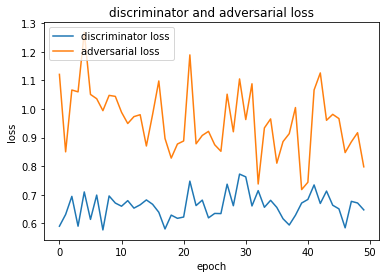

In [18]:
loss_plot() #dropout in generator, 50 epochs, dis learning rate - 0.0008, gen learning rate - 0.0004, 100 features

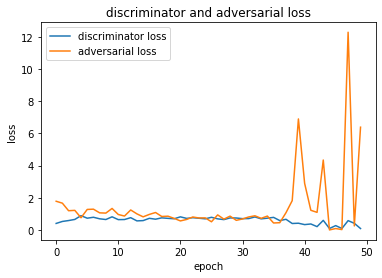

In [19]:
loss_plot() #50 epochs, dis learning rate - 0.002, gen learning rate - 0.0004, 300 features (very poor quality image output)

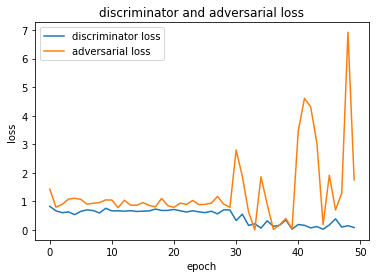

In [20]:
loss_plot() #no dropout in generator, 50 epochs, dis learning rate - 0.0008, gen learning rate - 0.0004, 100 features

When training, you may see the adversarial loss begin to increase considerably, while the discriminative loss tends to zero—the discriminator may end up dominating the generator. If that’s the case, try reducing the discriminator learning rate, and increase the dropout rate of the discriminator.

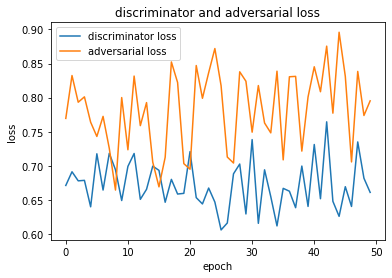

In [19]:
loss_plot() #50 epochs, dis learning rate - 0.0002, gen learning rate - 0.0004, 300 features, increased dropout in discriminator

both losses are now below 1 at all times but not particularly smooth

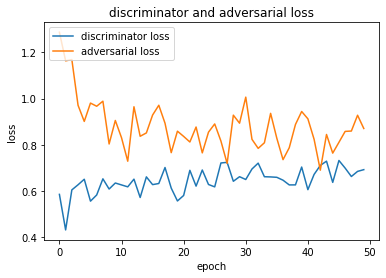

In [18]:
loss_plot() #50 epochs, dis learning rate - 0.0002, gen learning rate - 0.0001, 100 features

losses are below 1 and much smoother after lowering gen learning rate

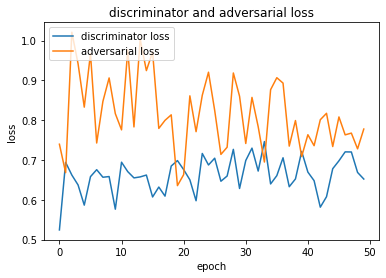

In [18]:
loss_plot() #50 epochs, dis learning rate - 0.0004, gen learning rate - 0.0002, 100 features

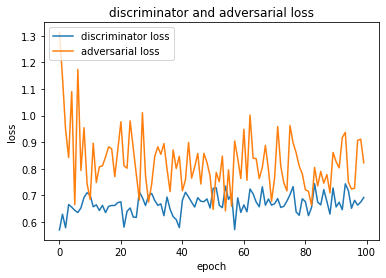

In [18]:
loss_plot() #100 epochs, dis learning rate - 0.0004, gen learning rate - 0.0002, 100 features

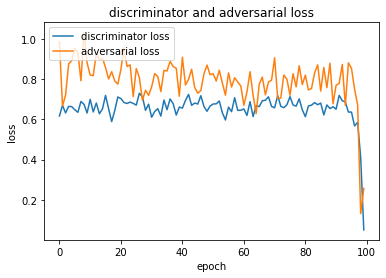

In [19]:
loss_plot() #100 epochs, dis learning rate - 0.0003, gen learning rate - 0.0002, 100 features

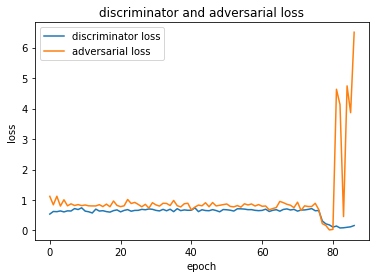

In [18]:
loss_plot()

It appears the best combination of learning rates is 0.0004 for the discriminator and 0.0002 for the generator when training for 100 epochs.

## Generate Synthetic Images with DCGAN

Now the generator and discriminator have been trained, the generator can be used to produce new images resembling the fashion mnist dataset. These images are being produced from just gaussian noise. The output shows that the network has learned a very accurate transformation from a very simple gaussian distribution.

In [1]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)

def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

show(generated_images, 8)

NameError: name 'tf' is not defined

After each epoch from training, the seed image was saved. These images can now be used to create a gif to evaluate the transformation over training time.

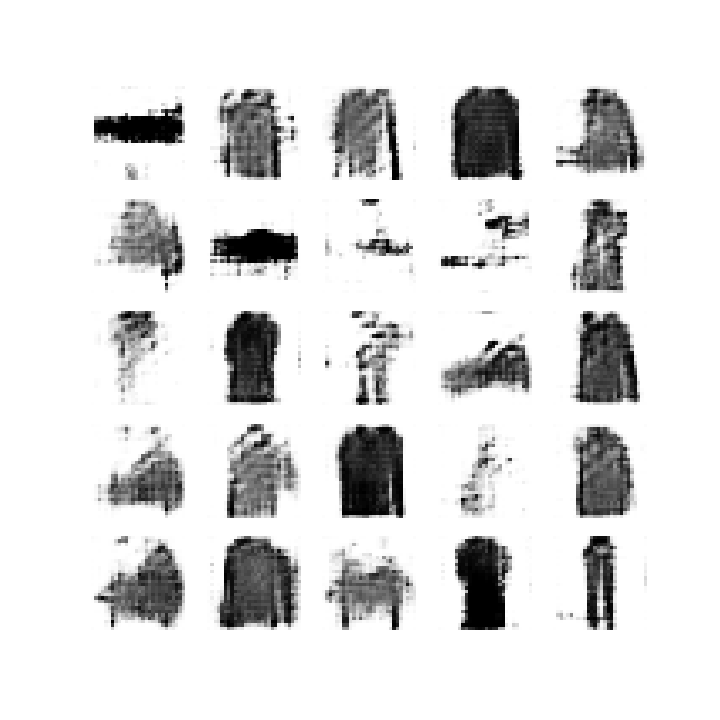

In [20]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('images/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)